# General setup

In [0]:
# first set whether this notebook is being run by you or by Elsevier supporters
permissions='default' # default or fulldata (default if by you)
# set the project name
project_name = '2706_causal_inference'
# if you want to run on the full data set, choose the cluster `csss-students-fulldata` and set the permissions variable to 'fulldata'
# this fulldata access will be available during the exercise session, and set back afterwards

In [0]:
%run /Snippets/header_latest

Running the header notebook for project `2706_causal_inference` with level `default`

# Load data

In [0]:
df_ani = spark.read.format("parquet").load(basePath+tablename_ani)         # Table of publications
df_fwci = spark.read.format("parquet").load(fwci_parquet_path)             # Table of some citation indicators

The following are the Scopus snapshot dates available for datasets at v007:
['v007.20210611182924/', 'v007.20210818120551/']
The most recent snapshot will be used unless specified otherwise. This is "v007.20210818120551/", (18 August 2021)
(If you want to use an earlier snapshot, in the first cell of your notebook, set the variable `custom_snapshot_date` to one of the options listed above (string data type))

You will use the latest snapshot date for this version v007.20210818120551/

Setting paths to run on sample datasets

# Peer review vs citations

In the UK, each few years there is a large-scale review exercise, called the Research Excellence Framework (REF), which assesses "research excellence" for institutions through peer review. These peer review results are used to distribute funding, and are also frequently used to produce league tables and rankings. This peer review exercise is quite extensive and is quite time consuming. Several people have asked whether it would be possible to obtain a similar result using citation indicators.

In this section, we will compare the review results from the REF with several citation indicators. In doing so, we hope to learn something that relates to causal inference.

We preloaded the data from the REF 2014 onto the platform (see https://www.ref.ac.uk/2014/ for details), so let us just first read those tables. 
These include all outputs that were submitted for review by the REF, which were published between 2008--2013, and the results of the peer review exercise. 
The results are not provided for each individual output that was submitted, but only at the institutional level, although separately per field of research (here called "Unit of Assessment").

Each ouput is awarded 1--4 stars, based on peer review of the output.
The overall score of each institution is presented as the percentage of outputs that was awarded 1--4 stars.

In [0]:
df_ref_outputs =  (
  spark
  .read
  .format("parquet")
  .load('s3a://elsevier-icsr-csss-uploads/REF_outputs_default_202206081019')
)
df_ref_results = ( 
  spark
  .read
  .format("parquet")
  .load('s3a://elsevier-icsr-csss-uploads/REF_results_default_202206081023')
)

Let's see what the different units of assessment (UoA) are and what the mean peer review scores are for each field.

In [0]:
display(
  df_ref_results
  .groupBy('Unit of assessment number', 'Unit of assessment name')
  .mean('4*', '3*', '2*', '1*')
  .orderBy('Unit of assessment number')
)

Unit of assessment number,Unit of assessment name,avg(4*),avg(3*),avg(2*),avg(1*)
1,Clinical Medicine,23.616129032258062,52.57741935483871,21.519354838709678,1.2999999999999996
2,"Public Health, Health Services and Primary Care",22.24375,47.54687500000001,25.471875000000004,3.9312500000000004
3,"Allied Health Professions, Dentistry, Nursing and Pharmacy",18.976344086021502,54.308602150537645,23.02258064516129,2.6086021505376347
4,"Psychology, Psychiatry and Neuroscience",18.520987654320987,41.82839506172839,33.056790123456786,5.560493827160494
5,Biological Sciences,24.181818181818183,47.38863636363636,23.768181818181823,2.461363636363636
6,"Agriculture, Veterinary and Food Science",16.879310344827587,48.81724137931036,29.451724137931038,3.7379310344827585
7,Earth Systems and Environmental Sciences,16.173333333333332,58.20222222222221,22.899999999999995,2.602222222222223
8,Chemistry,19.12702702702703,69.86486486486486,10.57027027027027,0.1918918918918919
9,Physics,19.502439024390252,66.00975609756098,13.773170731707312,0.4731707317073171
10,Mathematical Sciences,17.469811320754715,59.62452830188678,21.93584905660377,0.8622641509433961


We will restrict our focus to journal articles here, for which citations might be a more reasonable proxy.
Additionally, let us focus on one specific field: "Business and Management Studies", UoA number 19.

In [0]:
df_ref_articles_bms = (
  df_ref_outputs
  .filter("OutputType == 'D'")      # Only consider journal articles
  .filter("UnitOfAssessment == 19") # Only consider Business and Management Studies
)

Let us also get the results for Business and Management Studies.

In [0]:
df_ref_results_bms = (
  df_ref_results
  .filter('`Unit of assessment number` == 19')
)
display(df_ref_results_bms)

Institution code (UKPRN),Institution name,Institution sort order,Main panel,Unit of assessment number,Unit of assessment name,Multiple submission letter,Multiple submission name,Joint submission,Profile,FTE Category A staff submitted,4*,3*,2*,1*,unclassified
10006840,University of Birmingham,70,C,19,Business and Management Studies,,null,null,Outputs,53.1,17.2,39.7,35.3,7.3,0.5
10007140,Birmingham City University,80,C,19,Business and Management Studies,,null,null,Outputs,4.7,5.9,29.4,47.1,17.6,0.0
10000824,Bournemouth University,130,C,19,Business and Management Studies,,null,null,Outputs,20.5,4.6,38.5,46.1,10.8,0.0
10007785,University of Bradford,140,C,19,Business and Management Studies,,null,null,Outputs,19.2,18.3,38.0,39.5,4.2,0.0
10000886,University of Brighton,160,C,19,Business and Management Studies,,null,null,Outputs,15.8,17.4,34.8,36.2,10.2,1.4
10007786,University of Bristol,170,C,19,Business and Management Studies,,null,null,Outputs,27.5,15.3,56.5,28.2,0.0,0.0
10007141,University of Central Lancashire,250,C,19,Business and Management Studies,,null,null,Outputs,11.45,3.2,30.1,49.2,17.5,0.0
10007848,University of Chester,280,C,19,Business and Management Studies,,null,null,Outputs,6.0,4.3,4.4,34.8,56.5,0.0
10001478,City University London,300,C,19,Business and Management Studies,,null,null,Outputs,78.29,36.6,45.6,14.5,2.7,0.6
10001726,Coventry University,320,C,19,Business and Management Studies,,null,null,Outputs,17.0,4.5,27.3,45.5,22.7,0.0


We now have the peer review results ready for our analysis.
Let us now create some citation-based indicators for our analysis.
Some citation-based indicators are already pre-calculated for us, and are available from the `df_fwci` table.

**❓ Create a table `df_ref_articles_bms_fwci` by joining to `df_fwci`. Can you join directly to `df_fwci`? What type of join should you use here?**

In [0]:
df_ref_articles_bms_fwci = (
  df_ref_articles_bms
  .join(df_ani.select('eid', 'doi'), on='doi')
  .join(df_fwci, on='eid')
)

If you now take a look a the results, you will see a number of indicators that are available.
We refer to the [data documentation](https://icsrlab.cloud.databricks.com/#notebook/389/command/40126) for more details about these indicators.

The most relevant to us are:
- `Citations_5y`, the number of citations received within 5 years after publications and 
- `FWCI_5y`, the normalised citation indicator, based on `Citations_5y`.

The normalisation in the `FWCI_5y` is based on: (1) year of publication; (2) subject field; and (3) document type.

**❓ Given this normalistion, what variables do we (implicitly) control for in our analysis when using normalised citation indicators?**

Now the peer review results are available at the institutional level.
Let us also calculate citation-based indicators at the institutional level.
In this context, it would make sense to calculate means.

**❓ Can you group the article level results by institution (`UKPRN` is an institutional identifier) and calculate the mean of `Citations_5y` and `FWCI_5y`? Please call the result `df_ref_cit_results_bms`.**

In [0]:
df_ref_cit_results_bms = (
  df_ref_articles_bms_fwci
  .groupBy('UKPRN')
  .mean('Citations_5y', 'FWCI_5y')
)

Now let us create a dataframe that contains both the peer review results and the citation-based indicators.
That way, we can then easily compare them later.

In [0]:
df_ref_comparison = (
  df_ref_results_bms
  .withColumnRenamed('Institution code (UKPRN)', 'UKPRN')
  .join(df_ref_cit_results_bms,
        on='UKPRN',
        how='left'
       )
)

It is a bit easier to work with `pandas` instead of `pyspark` for some operations, including plotting. Our dataset is now also suficciently small that it is easy to work with using `pandas` instead of `pyspark.`

In [0]:
df = df_ref_comparison.select(['Unit of assessment number',
                               'Unit of assessment name',
                               'Institution name',
                               '4*',
                               'avg(Citations_5y)',
                               'avg(FWCI_5y)']).toPandas()

Now let us calculate a correlation with these citation indicators and the `4*` peer review results.

In [0]:
df[['avg(Citations_5y)', 'avg(FWCI_5y)']].corrwith(df['4*'])

Out[17]: avg(Citations_5y) 0.415771
avg(FWCI_5y) 0.349880
dtype: float64

Let us also plot the results to inspect the results in more detail.
Let us first load the necessary libraries.

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

Now we can plot the results.

Out[19]:

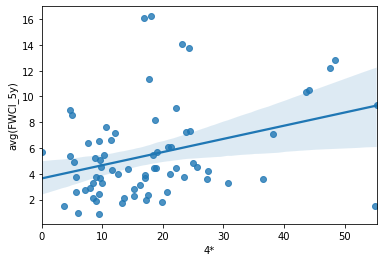

<AxesSubplot:xlabel='4*', ylabel='avg(FWCI_5y)'>

In [0]:
sns.regplot(data=df, x='4*', y='avg(FWCI_5y)')

Out[20]:

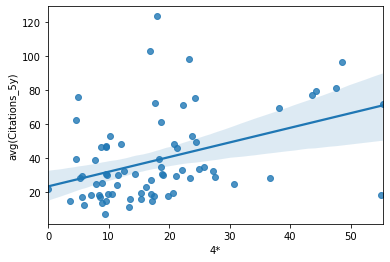

<AxesSubplot:xlabel='4*', ylabel='avg(Citations_5y)'>

In [0]:
sns.regplot(data=df, x='4*', y='avg(Citations_5y)')

**❓ The correlations with peer review results based on `Citations_5y` and `FWCI_5y` are not that different. Why do you think this is? What does this say about a potential causal model of peer review and citations?**

## Journal-based normalisation

Now let us try to see what happens if we normalise for the journal, instead of for the field.
This is not a normalisation that is available by default, so we will have to calculate it ourselves.

**❓ Could you join to `df_ani` to add the journal ID and title to the FWCI information? What join should you use here?**

In [0]:
df_source_cits = (
  df_fwci
  .join(df_ani.select('doi', 'eid', 'source.srcid', 'source.sourcetitle', 'Year'),
        on='eid', 
        how='right'
       )
)

**❓ Now group by the `srcid` and the `year` to calculate the mean number of `Citations_5y` for each journal, for each year.**

In [0]:
df_avg_source_cits = (
  df_source_cits
  .groupby('srcid', 'year')
  .mean('Citations_5y')
)

We now calculate our new journal-based normalised citation indicator `JWCI_5y` and add it to the citation-based indicators.

In [0]:
df_fwci_extended = (
  df_source_cits
  .join(df_avg_source_cits.withColumnRenamed('avg(Citations_5y)', 'Expected_J5y'), 
        on=['srcid', 'year'])
  .withColumn('JWCI_5y',
              func.col('Citations_5y')/func.col('Expected_J5y')) # Calculate normalised indicator
)

Now we can repeat our previous analysis, but add our new citation indicator `JWCI_5y`.

In [0]:
# Add citation metrics
df_ref_articles_bms_fwci = (
  df_ref_articles_bms
  .join(df_ani.select('eid', 'doi'), on='doi')
  .join(df_fwci_extended, on='eid')
)

# Group by institution and take average
df_ref_cit_results_bms = (
  df_ref_articles_bms_fwci
  .groupBy('UKPRN')
  .mean('Citations_5y', 'FWCI_5y', 'JWCI_5y')
)

# Do the comparison again
df_ref_comparison = (
  df_ref_results_bms
  .withColumnRenamed('Institution code (UKPRN)', 'UKPRN')
  .join(df_ref_cit_results_bms,
        on='UKPRN',
        how='left'
       )
)

df = df_ref_comparison.select(['Unit of assessment number',
                               'Unit of assessment name',
                               'Institution name',
                               '4*',
                               'avg(Citations_5y)',
                               'avg(FWCI_5y)',
                               'avg(JWCI_5y)']).toPandas()

**❓ Can you calculate the correlations between the citation-based indicators and the percentage of 4\* papers?**

In [0]:
df[['avg(Citations_5y)', 'avg(FWCI_5y)', 'avg(JWCI_5y)']].corrwith(df['4*'])

Out[25]: avg(Citations_5y) 0.415771
avg(FWCI_5y) 0.349880
avg(JWCI_5y) 0.004632
dtype: float64

**❓ Can you plot the percentage of 4\* papers against the `JWCI_5y` indicator?**

Out[26]:

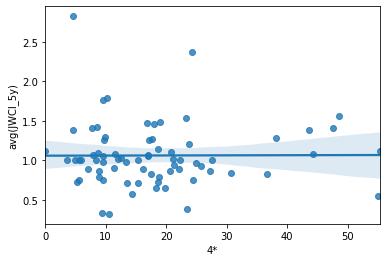

<AxesSubplot:xlabel='4*', ylabel='avg(JWCI_5y)'>

In [0]:
sns.regplot(data=df, x='4*', y='avg(JWCI_5y)')

**❓ The correlations with peer review results based on `JWCI_5y` is quite different from the correlations we observed earlier. Why do you think this is?**

**❓ What does this say about a potential causal model of peer review and citations? How does "Research Excellence" fit into that causal model?**

If you have time left you can consider the following possibility.

**❓ Could you repeat the same analysis for other fields? Or perhaps for *all* fields simultaneously? How doest this change your earlier ideas of a potential causal model?**